In [26]:
! pip install -r requirements.txt --q

In [32]:
!pip install torch

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/204.1 MB 1.9 MB/s eta 0:01:49
   ---------------------------------------- 0.8/204.1 MB 1.9 MB/s eta 0:01:49
   ---------------------------------------- 1.6/204.1 MB 2.0 MB/s eta 0:01:44
   ---------------------------------------- 1.8/204.1 MB 1.8 MB/s eta 0:01:55
   ---------------------------------------- 1.8/204.1 MB 1.8 MB/s eta 0:01:55
   ---------------------------------------- 2.4/204.1 MB 1.7 MB/s eta 0:01:56
    --------------------------------------- 2.9/204.1 MB 1.8 MB/s eta 0:01:54
    --------------------------------------- 3.4/204.1 MB 1.8 MB/s eta 0:01:52
    --------------------------------------- 3.7/204.1 MB 1.8 MB/s eta 0:01:52
    --------------------------------------- 4.2/204.1 MB 1.8 MB/s eta 0:01:51
    --------------------------------------- 4.5/204.1 MB 1.8 MB/s eta 0:01:49


In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from tqdm import tqdm
import osmnx as ox
import geopandas as gpd
import datetime
import gc
import sys
import pandas as pd
import torch
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx
from haversine import haversine, Unit

pd.set_option('display.max_columns', None)

In [3]:
# Create dictionary for mapping of VehId to Vehicle_Type
df_IceHev = pd.read_excel ('VED-master\Data\VED_Static_Data_ICE&HEV.xlsx')
df_IceHev.rename(columns={'Vehicle Type': 'Vehicle_Type'}, inplace=True)
df_PhevEv = pd.read_excel ('VED-master\Data\VED_Static_Data_PHEV&EV.xlsx')
df_PhevEv.rename(columns={'EngineType': 'Vehicle_Type'}, inplace=True)
df_VehId = pd.concat([df_IceHev, df_PhevEv], ignore_index = True)
df_VehId.sort_values(by='VehId', inplace=True)
df_VehId

,VehId,Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,2,ICE,Car,4-FI 2.0L T/C,NO DATA,NO DATA,3500
1,5,HEV,Car,4-GAS/ELECTRIC 2.0L,NO DATA,NO DATA,3500
2,7,ICE,SUV,6-FI 3.6L,AUTOMATIC,NO DATA,4500
3,8,ICE,Car,4-FI 1.5L,5-SP MANUAL,NO DATA,2500
357,9,PHEV,Car,4-GAS/ELECTRIC 1.4L,NO DATA,FWD,4000
...,...,...,...,...,...,...,...
352,616,ICE,NO DATA,V6 3.5L,5-SP Automatic,NO DATA,NO DATA
353,618,ICE,NO DATA,V6 3.5L,4-SP Automatic,NO DATA,NO DATA
354,624,ICE,NO DATA,H-4 2.5L,5-SP Automatic,NO DATA,NO DATA
355,625,ICE,NO DATA,I-4 1.8L,CVT,NO DATA,3000


In [4]:
%%time
df_list = []
input_dir = "datarepo-eved-dataset-549403600cf5/data/eVED/"
file_list = os.listdir(input_dir)
file_list = [file for file in file_list if file.endswith("_week.csv")]

for i in range(len(file_list)):
    df = pd.read_csv(input_dir + file_list[i], low_memory=False)
    print(f"Reading file ({i+1}/{len(file_list)}): {file_list[i]} (len = {len(df)})")
    df = df[df['Energy_Consumption'].notnull()]
    df_list.append(df)

raw_df = pd.concat(df_list)
print("=============================================")
print(f"Total records: {len(raw_df)}")

Reading file (1/54): eVED_171101_week.csv (len = 489414)
Reading file (2/54): eVED_171108_week.csv (len = 535198)
Reading file (3/54): eVED_171115_week.csv (len = 602092)
Reading file (4/54): eVED_171122_week.csv (len = 474329)
Reading file (5/54): eVED_171129_week.csv (len = 531856)
Reading file (6/54): eVED_171206_week.csv (len = 589154)
Reading file (7/54): eVED_171213_week.csv (len = 670084)
Reading file (8/54): eVED_171220_week.csv (len = 539468)
Reading file (9/54): eVED_171227_week.csv (len = 311927)
Reading file (10/54): eVED_180103_week.csv (len = 393498)
Reading file (11/54): eVED_180110_week.csv (len = 550780)
Reading file (12/54): eVED_180117_week.csv (len = 526771)
Reading file (13/54): eVED_180124_week.csv (len = 456757)
Reading file (14/54): eVED_180131_week.csv (len = 479522)
Reading file (15/54): eVED_180207_week.csv (len = 419846)
Reading file (16/54): eVED_180214_week.csv (len = 389642)
Reading file (17/54): eVED_180221_week.csv (len = 285924)
Reading file (18/54): e

In [5]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 308
Total unique trips: 24064


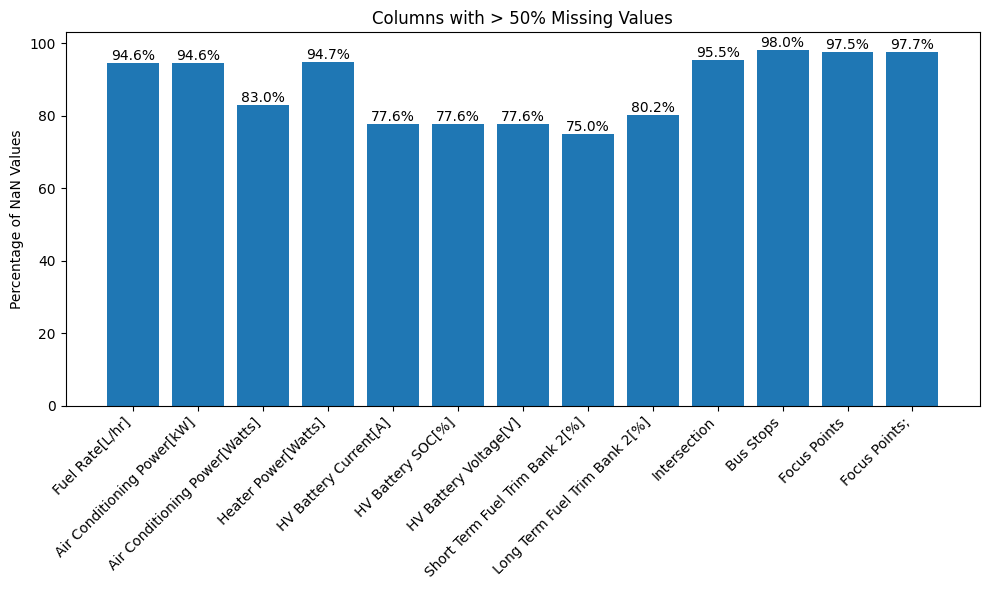

CPU times: total: 9.69 s
Wall time: 10.3 s


In [6]:
%%time
# Drop columns with >50% NaN values
nan_percentages = (raw_df.isna().sum() / len(raw_df)) * 100

# Filter columns with >80% NaN values
high_nan_cols = nan_percentages[nan_percentages > 50]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(high_nan_cols)), high_nan_cols.values)
plt.xticks(range(len(high_nan_cols)), high_nan_cols.index, rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values')  
plt.title('Columns with > 50% Missing Values')

# Add percentage labels on top of bars
for i, v in enumerate(high_nan_cols.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

raw_df.drop(columns=high_nan_cols.index, inplace=True)

In [7]:
# drop rows with NaN values 
raw_df.dropna(how='any', axis=0, inplace=True)

In [8]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 167
Total unique trips: 9009


In [9]:
raw_df = raw_df.merge(df_VehId, on='VehId', how='left')
raw_df

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,85.847662,157.0,2481.0,0.0,42.255103,-83.686560,51.0,4.84,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001526,42.255053,-83.686578,0,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
1,85.847662,157.0,2481.0,1300.0,42.255103,-83.686560,52.0,5.21,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
2,85.847662,157.0,2481.0,2000.0,42.255103,-83.686560,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.156158,-0.006169,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
3,85.847662,157.0,2481.0,2900.0,42.254983,-83.685861,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.790756,0.000000,0.001675,42.254925,-83.685880,0,0.0,72,72.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
4,85.847662,157.0,2481.0,3700.0,42.254983,-83.685861,53.0,7.27,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.425354,0.000000,0.002382,42.254925,-83.685880,1,0.0,72,72.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455857,375.499059,458.0,2473.0,229100.0,42.258769,-83.677832,71.0,15.12,1195.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.389923,0.000000,0.006860,42.258992,-83.677841,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455858,375.499059,458.0,2473.0,230200.0,42.258769,-83.677832,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.435013,0.000561,0.005636,42.258992,-83.677841,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455859,375.499059,458.0,2473.0,231000.0,42.258805,-83.676859,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.570282,236.480103,0.000000,0.005636,42.259011,-83.676867,0,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455860,375.499059,458.0,2473.0,231200.0,42.258805,-83.676859,69.0,12.60,1302.0,45.490196,4.0,-1.56250,-0.78125,236.570282,236.570282,0.000000,0.005646,42.259011,-83.676867,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500


In [10]:
for col in df_VehId.columns:
    print(f"{col}: {raw_df[col].value_counts().get('NO DATA', 0) / len(raw_df) * 100:.2f}% 'NO DATA'")

VehId: 0.00% 'NO DATA'
Vehicle_Type: 0.00% 'NO DATA'
Vehicle Class: 99.82% 'NO DATA'
Engine Configuration & Displacement: 0.00% 'NO DATA'
Transmission: 92.23% 'NO DATA'
Drive Wheels: 100.00% 'NO DATA'
Generalized_Weight: 0.47% 'NO DATA'


In [12]:
raw_df.drop(columns=['Vehicle Class', 'Transmission', 'Drive Wheels'], inplace=True)

In [14]:
raw_df = raw_df[(raw_df['Vehicle_Type']!= 'NO DATA') & (raw_df['Generalized_Weight']!= 'NO DATA')]
raw_df

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,85.847662,157.0,2481.0,0.0,42.255103,-83.686560,51.0,4.84,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001526,42.255053,-83.686578,0,0.0,64,64.0,ICE,6-FI 3.5L,3500
1,85.847662,157.0,2481.0,1300.0,42.255103,-83.686560,52.0,5.21,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,6-FI 3.5L,3500
2,85.847662,157.0,2481.0,2000.0,42.255103,-83.686560,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.156158,-0.006169,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,6-FI 3.5L,3500
3,85.847662,157.0,2481.0,2900.0,42.254983,-83.685861,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.790756,0.000000,0.001675,42.254925,-83.685880,0,0.0,72,72.0,ICE,6-FI 3.5L,3500
4,85.847662,157.0,2481.0,3700.0,42.254983,-83.685861,53.0,7.27,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.425354,0.000000,0.002382,42.254925,-83.685880,1,0.0,72,72.0,ICE,6-FI 3.5L,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455857,375.499059,458.0,2473.0,229100.0,42.258769,-83.677832,71.0,15.12,1195.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.389923,0.000000,0.006860,42.258992,-83.677841,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455858,375.499059,458.0,2473.0,230200.0,42.258769,-83.677832,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.435013,0.000561,0.005636,42.258992,-83.677841,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455859,375.499059,458.0,2473.0,231000.0,42.258805,-83.676859,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.570282,236.480103,0.000000,0.005636,42.259011,-83.676867,0,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455860,375.499059,458.0,2473.0,231200.0,42.258805,-83.676859,69.0,12.60,1302.0,45.490196,4.0,-1.56250,-0.78125,236.570282,236.570282,0.000000,0.005646,42.259011,-83.676867,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500


In [15]:
# Convert Timestamp(ms) to seconds and add to base_date
raw_df.drop(columns=['DayNum', 'Latitude[deg]', 'Longitude[deg]', 'Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]' ], inplace=True)

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_24428\3756966594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.drop(columns=['DayNum', 'Latitude[deg]', 'Longitude[deg]', 'Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]' ], inplace=True)


In [ ]:
raw_df.to_csv("DATA/data.csv", index=False)

In [21]:

# Get initial memory info
before = len(gc.get_objects())

# Clear large dataframes and lists
del df_list
del raw_df
del df_IceHev
del df_PhevEv
del df_VehId
del df
del high_nan_cols
del nan_percentages

# Clear other variables
for name in list(globals().keys()):
    if not name.startswith('_') and name != 'gc' and name != 'sys':
        try:
            del globals()[name]
        except:
            pass

# Force garbage collection
gc.collect()

# Get memory info after cleanup
after = len(gc.get_objects())
print(f"Objects before: {before}, Objects after: {after}")
print(f"Objects freed: {before - after}")

NameError: name 'df_list' is not defined

## 2. Preprocessing

In [ ]:
full_df = pd.read_csv("DATA/raw_data.csv", low_memory=False)
full_df

,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,157.0,2481.0,0.0,51.0,4.84,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,0.000000,0.001526,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
1,157.0,2481.0,1300.0,52.0,5.21,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,0.000000,0.001675,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
2,157.0,2481.0,2000.0,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,248.156158,-0.006169,0.001675,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
3,157.0,2481.0,2900.0,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,247.790756,0.000000,0.001675,42.254925,-83.685880,72,ICE,6-FI 3.5L,3500
4,157.0,2481.0,3700.0,53.0,7.27,1095.0,17.254902,15.0,2.34375,-9.37500,247.425354,0.000000,0.002382,42.254925,-83.685880,72,ICE,6-FI 3.5L,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430049,458.0,2473.0,229100.0,71.0,15.12,1195.0,45.490196,4.0,-3.12500,-0.78125,236.389923,0.000000,0.006860,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430050,458.0,2473.0,230200.0,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.435013,0.000561,0.005636,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430051,458.0,2473.0,231000.0,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.480103,0.000000,0.005636,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430052,458.0,2473.0,231200.0,69.0,12.60,1302.0,45.490196,4.0,-1.56250,-0.78125,236.570282,0.000000,0.005646,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500


In [41]:
temp_df = full_df[(full_df['VehId']==458) & (full_df['Trip']==2473)]
temp_df

,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
5429792,458.0,2473.0,0.0,29.0,8.170000,1242.0,47.450981,5.0,-9.3750,2.34375,254.539612,0.000000,0.001465,42.245611,-83.680474,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5429793,458.0,2473.0,800.0,29.0,27.750000,1460.0,47.450981,5.0,-9.3750,2.34375,254.539612,0.000000,0.004975,42.245611,-83.680474,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5429794,458.0,2473.0,1800.0,31.0,27.750000,1460.0,47.450981,5.0,-9.3750,2.34375,254.580579,0.000000,0.005319,42.245611,-83.680474,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5429795,458.0,2473.0,2900.0,36.0,34.810001,2646.0,47.450981,5.0,-9.3750,2.34375,254.621545,0.001526,0.007748,42.245611,-83.680474,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5429796,458.0,2473.0,3100.0,36.0,34.810001,2646.0,47.450981,5.0,-9.3750,2.34375,254.662512,0.000000,0.007748,42.245846,-83.680482,72,HEV,4-GAS/ELECTRIC 2.4L,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430049,458.0,2473.0,229100.0,71.0,15.120000,1195.0,45.490196,4.0,-3.1250,-0.78125,236.389923,0.000000,0.006860,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430050,458.0,2473.0,230200.0,70.0,12.600000,1302.0,45.490196,4.0,-3.1250,-0.78125,236.435013,0.000561,0.005636,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430051,458.0,2473.0,231000.0,70.0,12.600000,1302.0,45.490196,4.0,-3.1250,-0.78125,236.480103,0.000000,0.005636,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430052,458.0,2473.0,231200.0,69.0,12.600000,1302.0,45.490196,4.0,-1.5625,-0.78125,236.570282,0.000000,0.005646,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500


In [ ]:
class Trip:
    def __init__(self, vehicle_id, trip_id, data=None):
        """
        Initialize a Trip object
        
        Parameters:
        -----------
        vehicle_id : int or float
            Vehicle identifier
        trip_id : int or float
            Trip identifier
        data : pandas.DataFrame, optional
            DataFrame containing trip data
        """
        self.vehicle_id = vehicle_id
        self.trip_id = trip_id
        self.data = data if data is not None else self._load_data()
        
    def _load_data(self):
        """Load trip data from the full dataframe"""
        if 'full_df' in globals():
            return full_df[(full_df['VehId'] == self.vehicle_id) & 
                          (full_df['Trip'] == self.trip_id)].copy().reset_index(drop=True)
        else:
            raise ValueError("Full dataframe not available")
    
    def get_duration(self):
        """Return trip duration in seconds"""
        if self.data is None or len(self.data) == 0:
            return 0
        max_timestamp = self.data['Timestamp(ms)'].max()
        min_timestamp = self.data['Timestamp(ms)'].min()
        return (max_timestamp - min_timestamp) / 1000  # Convert to seconds
    
    def get_distance(self):
        """Estimate trip distance in meters using haversine formula"""
        if self.data is None or len(self.data) < 2:
            return 0
        
        total_distance = 0
        for i in range(len(self.data) - 1):
            curr_node = (self.data.loc[i, 'Matchted Latitude[deg]'], 
                         self.data.loc[i, 'Matched Longitude[deg]'])
            next_node = (self.data.loc[i+1, 'Matchted Latitude[deg]'], 
                         self.data.loc[i+1, 'Matched Longitude[deg]'])
            
            distance = haversine(curr_node, next_node, unit=Unit.METERS)
            total_distance += distance
            
        return total_distance
    
    def get_total_energy(self):
        """Return total energy consumption for the trip"""
        if self.data is None or len(self.data) == 0:
            return 0
        return self.data['Energy_Consumption'].sum()
    
    def get_average_speed(self):
        """Return average speed in km/h"""
        if self.data is None or len(self.data) == 0:
            return 0
        return self.data['Vehicle Speed[km/h]'].mean()
    
    def get_max_speed(self):
        """Return maximum speed in km/h"""
        if self.data is None or len(self.data) == 0:
            return 0
        return self.data['Vehicle Speed[km/h]'].max()
    
    def get_vehicle_type(self):
        """Return vehicle type"""
        if self.data is None or len(self.data) == 0:
            return None
        return self.data['Vehicle_Type'].iloc[0]
    
    def get_summary(self):
        """Return summary statistics of the trip"""
        return {
            'vehicle_id': self.vehicle_id,
            'trip_id': self.trip_id,
            'duration_sec': self.get_duration(),
            'distance_m': self.get_distance(),
            'total_energy': self.get_total_energy(),
            'avg_speed_kmh': self.get_average_speed(),
            'max_speed_kmh': self.get_max_speed(),
            'vehicle_type': self.get_vehicle_type(),
            'data_points': len(self.data) if self.data is not None else 0
        }
    
    def plot_trip(self, figsize=(15, 10)):
        """Generate plots for trip visualization"""
        if self.data is None or len(self.data) == 0:
            print("No data available for plotting")
            return
            
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=figsize)
        
        # Plot 1: Speed over time
        plt.subplot(2, 2, 1)
        plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Vehicle Speed[km/h]'], 'b-')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Speed (km/h)')
        plt.title('Speed Profile')
        plt.grid(True)
        
        # Plot 2: Energy consumption over time
        plt.subplot(2, 2, 2)
        plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Energy_Consumption'], 'r-')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Energy Consumption')
        plt.title('Energy Consumption Profile')
        plt.grid(True)
        
        # Plot 3: Elevation over time
        plt.subplot(2, 2, 3)
        plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Elevation Smoothed[m]'], 'g-')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Elevation (m)')
        plt.title('Elevation Profile')
        plt.grid(True)
        
        # Plot 4: Trip route on map (if folium is available)
        plt.subplot(2, 2, 4)
        plt.scatter(self.data['Matched Longitude[deg]'], self.data['Matchted Latitude[deg]'], 
                   c=self.data['Timestamp(ms)'], cmap='viridis', s=10)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Trip Route')
        plt.grid(True)
        plt.colorbar(label='Time')
        
        plt.tight_layout()
        plt.show()

Index(['VehId', 'Trip', 'Timestamp(ms)', 'Vehicle Speed[km/h]', 'MAF[g/sec]',
       'Engine RPM[RPM]', 'Absolute Load[%]', 'OAT[DegC]',
       'Short Term Fuel Trim Bank 1[%]', 'Long Term Fuel Trim Bank 1[%]',
       'Elevation Smoothed[m]', 'Gradient', 'Energy_Consumption',
       'Matchted Latitude[deg]', 'Matched Longitude[deg]', 'Speed Limit[km/h]',
       'Vehicle_Type', 'Engine Configuration & Displacement',
       'Generalized_Weight'],
      dtype='object')

In [ ]:

%%time
# 15mins
G = nx.DiGraph()

# Iterate through trips to add nodes and edges
for (veh_id, trip), trip_df in tqdm(full_df.groupby(['VehId', 'Trip'])):
    trip_df = trip_df.reset_index(drop=True)

    for i in range(len(trip_df) - 1):
        current = trip_df.loc[i]
        next_point = trip_df.loc[i + 1]

        # Node definitions (latitude, longitude)
        curr_node = (current['Matchted Latitude[deg]'], current['Matched Longitude[deg]'])
        next_node = (next_point['Matchted Latitude[deg]'], next_point['Matched Longitude[deg]'])

        # Add node attributes
        if curr_node not in G:
            G.add_node(curr_node,
                    latitude=current['Matchted Latitude[deg]'],
                    longitude=current['Matched Longitude[deg]'],
                    elevation=current['Elevation Smoothed[m]'])

        if next_node not in G:
            G.add_node(next_node,
                    latitude=next_point['Matchted Latitude[deg]'],
                    longitude=next_point['Matched Longitude[deg]'],
                    elevation=next_point['Elevation Smoothed[m]'])

        # Compute distance
        distance = haversine(curr_node, next_node, unit=Unit.METERS)

        # Edge attributes
        G.add_edge(curr_node, 
                next_node,
                distance=distance,
                gradient=next_point['Gradient'],
                energy_consumption=next_point['Energy_Consumption'],
                vehicle_speed=next_point['Vehicle Speed[km/h]'],
                temperature=next_point['OAT[DegC]'],
                engine_rpm=next_point['Engine RPM[RPM]'],
                absolute_load=next_point['Absolute Load[%]'])


100%|██████████| 8972/8972 [13:25<00:00, 11.13it/s]


In [36]:
# Convert to PyTorch Geometric format (automatically handles indexing)
pyg_data = from_networkx(G)

# Example of normalization (optional but recommended)
# Normalize Node Elevation
elevation = torch.tensor([attr['elevation'] for _, attr in G.nodes(data=True)], dtype=torch.float32)
elev_mean, elev_std = elevation.mean(), elevation.std()
pyg_data.x = ((elevation - elev_mean) / elev_std).unsqueeze(1)  # Node features in PyG (N, 1)

# Normalize Edge attributes
edge_attrs = ['distance', 'gradient', 'energy_consumption', 'vehicle_speed',
            'temperature', 'engine_rpm', 'absolute_load']

edge_features = []
for attr in edge_attrs:
    vals = torch.tensor([G[u][v][attr] for u, v in G.edges()], dtype=torch.float32)
    mean, std = vals.mean(), vals.std()
    normalized = (vals - mean) / std
    edge_features.append(normalized.unsqueeze(1))

# Concatenate edge features
pyg_data.edge_attr = torch.cat(edge_features, dim=1)

# Check resulting PyG data
print(pyg_data)
print("Node feature shape:", pyg_data.x.shape)
print("Edge feature shape:", pyg_data.edge_attr.shape)


Data(edge_index=[2, 1949562], latitude=[861182], longitude=[861182], elevation=[861182], distance=[1949562], gradient=[1949562], energy_consumption=[1949562], vehicle_speed=[1949562], temperature=[1949562], engine_rpm=[1949562], absolute_load=[1949562], num_nodes=861182, x=[861182, 1], edge_attr=[1949562, 7])
Node feature shape: torch.Size([861182, 1])
Edge feature shape: torch.Size([1949562, 7])
